### Group 28 members:
- Jingze Tian (CCID)
- Letian Ren (CCID)
- Essam Gouda (egouda)

# Task 1: Regression
- Linear Regression for no_of_Mosquito = function(weather_features)
- Linear Regression for no_of_Mosquito_female = function(weather_features)
- Linear Regression for no_of_Mosquito_male = function(weather_features)
- Polynomial Regression for no_of_Mosquito_female = function(weather_features)
- Polynomial Regression for no_of_Mosquito_male = function(weather_features)

#### Variations for each model:
- Different cost functions were tested
- Model without normalization and standardization, model with normalization only, model with standardization only, model with both normalization and standardization.
- Feature selection
- model statistics compared at the end

## Imports

In [1]:
import pandas as pd
import numpy as np
import time


import matplotlib.pyplot as plt
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white bg for sns plots
sns.set(style="whitegrid", color_codes=True)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

from scipy.stats import ks_2samp

import warnings; warnings.simplefilter('ignore')

## Read csv files (datasets)

In [2]:
weather_data = pd.read_csv('./data/weather_data.csv')
mos_data = pd.read_csv('./data/mosquito_data_new.csv')

In [3]:
mos_data.head()

,Trap Date,Genus,Specific Epithet,Gender,IDd,Count,Trap Region,Include,Comparison Group,Latitude,Longitude,Location
0,09/15/2015 12:00:00 AM,Aedes,vexans,Female,NaN,3,Rural-West,NaN,Outer,53.562973,-113.787353,POINT (-113.787353 53.5629733)
1,05/12/1998 12:00:00 AM,Male,UnID,Male,UnID,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
2,08/28/2001 12:00:00 AM,Culex,tarsalis,Female,NaN,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
3,08/17/2004 12:00:00 AM,Culex,territans,Female,NaN,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
4,05/15/2018 12:00:00 AM,Culiseta,impatiens,Female,NaN,2,Rural-West,NaN,Outer,53.559020,-114.001190,POINT (-114.00119 53.559020000000004)


In [4]:
weather_data.head()

,date_time_local,unixtime,pressure_station,pressure_sea,wind_dir,wind_dir_10s,wind_speed,wind_gust,relative_humidity,dew_point,temperature,windchill,humidex,visibility,health_index,cloud_cover_4,cloud_cover_8,cloud_cover_10,solar_radiation
0,2018-12-18 16:00:00 MST,1545174000,91.73,99.7,SW,23.0,5.0,NaN,64.0,-7.3,-1.3,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-12-18 15:00:00 MST,1545170400,91.67,99.7,S,18.0,5.0,NaN,65.0,-6.3,-0.5,-2.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN
2,2018-12-18 14:00:00 MST,1545166800,91.67,99.6,S,17.0,5.0,NaN,51.0,-6.5,2.7,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
3,2018-12-18 13:00:00 MST,1545163200,91.66,99.6,SE,13.0,2.0,NaN,50.0,-6.4,2.9,NaN,NaN,NaN,3.9,NaN,NaN,NaN,NaN
4,2018-12-18 12:00:00 MST,1545159600,91.75,99.7,NaN,NaN,0.0,NaN,59.0,-6.6,0.5,NaN,NaN,NaN,4.1,NaN,NaN,NaN,NaN


### Get total count for each day

In [5]:
mos_count = mos_data.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count[mos_count['Count'] == mos_count['Count'].max()]

mos_count.head() ####number of mos

,Count
Trap Date,
04/08/1992 12:00:00 AM,604
05/05/1992 12:00:00 AM,120
05/05/2020 12:00:00 AM,8
05/07/2013 12:00:00 AM,4
05/07/2019 12:00:00 AM,1


In [6]:
len(mos_count.index)

584

It can be seen that IDd and Include columns contains many NaN values so they will be dropped

In [7]:
mos_data.isnull().sum()

Trap Date               0
Genus                   4
Specific Epithet        4
Gender                  4
IDd                 20205
Count                   0
Trap Region             4
Include             26434
Comparison Group        4
Latitude                4
Longitude               4
Location                4
dtype: int64

In [8]:
mos_data.drop(columns=['IDd', 'Include'], inplace=True)

In [9]:
mos_data.isnull().sum()

Trap Date           0
Genus               4
Specific Epithet    4
Gender              4
Count               0
Trap Region         4
Comparison Group    4
Latitude            4
Longitude           4
Location            4
dtype: int64

### Select date for weather features and mosquito data

Drop MST columns
Drop columns with too many NaNs
Drop unixtime columns as they are redundent
Drop wind_dir column as wind_dir_10s gives us the angle of the wind so its redundent

### Date selection

In [10]:
t_list = []
for i in mos_data['Trap Date']:
    i = str(i)
    t1 = time.strptime(i,"%m/%d/%Y %H:%M:%S AM")
    t2 = time.strftime("%Y-%m-%d", t1)
    t_list.append(t2)

mos_data['Trap Date'] = t_list


mos_data['Trap Date'] = pd.to_datetime(mos_data['Trap Date'])

############data select#############
start_remove = min(weather_data['date_time_local'])
end_remove = max(weather_data['date_time_local'])
mos_data_1 = mos_data.loc[(mos_data["Trap Date"] >= start_remove) & (mos_data["Trap Date"] <= end_remove) ]
mos_date_start = str(mos_data_1['Trap Date'].dt.date.min())
mos_date_end = str(mos_data_1['Trap Date'].dt.date.max())
mos_date_range = mos_date_start +' to ' + mos_date_end
print("Range of dates in mosquito dataset is {}".format(mos_date_range))

mos_data['Trap Date'] = pd.to_datetime(mos_data['Trap Date'])
mos_range = (mos_data['Trap Date'] >= mos_date_start) & (mos_data['Trap Date'] <= mos_date_end)
mos_data = mos_data.loc[mos_range]
mos_data = mos_data.sort_values(by='Trap Date')


mos_count = mos_data.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count[mos_count['Count'] == mos_count['Count'].max()]

Range of dates in mosquito dataset is 2017-05-09 to 2018-09-25


,Count
Trap Date,
2018-06-12,9938


In [11]:
start_date1 = '2017-05-03' #one week before 2017-05-09
end_date1 = '2017-09-26'
start_date2 = '2018-05-09' #one week before 2018-05-15
end_date2 = '2018-09-25'

##############Drop MST###################
weather_data.drop(columns=["visibility", "cloud_cover_4", "cloud_cover_8", "cloud_cover_10", "solar_radiation", "wind_gust", "windchill", "humidex"], inplace=True)
weather_data = weather_data.loc[weather_data['date_time_local'].str.contains('MDT')]


t_list = []
for i in weather_data['date_time_local']:
    i = str(i)
    t1 = time.strptime(i,"%Y-%m-%d %H:%M:%S MDT")
    t2 = time.strftime("%Y-%m-%d", t1)
    t_list.append(t2)

weather_data['date_time_local'] = t_list


weather_data['date_time_local'] = pd.to_datetime(weather_data['date_time_local'])
weather_range1 = (weather_data['date_time_local'] >= start_date1) & (weather_data['date_time_local'] <= end_date1)
weather_data1 = weather_data.loc[weather_range1]
weather_data1 = weather_data1.sort_values(by='date_time_local')


weather_range2 = (weather_data['date_time_local'] >= start_date2) & (weather_data['date_time_local'] <= end_date2)
weather_data2 = weather_data.loc[weather_range2]
weather_data2 = weather_data2.sort_values(by='date_time_local')
weather_data = weather_data1.append(weather_data2)

#### Fill NaN for weather_data

In [12]:
weather_data.isnull().sum()

date_time_local       0
unixtime              0
pressure_station      1
pressure_sea          1
wind_dir             50
wind_dir_10s         11
wind_speed            1
relative_humidity     1
dew_point             1
temperature           1
health_index         50
dtype: int64

In [13]:
len(weather_data.index)

6888

#### To fill the NaNs we will group the weather data by day and there is 3 ways to do that for each column:
- By mean
- By mode
- By median

for each day, to do so we will need to visualize the distribution for each column and ensure that it stays similar after grouping to not add any bias to the data.

### Pressure station

In [14]:
weather_data['pressure_station'].describe()

count    6887.000000
mean       93.554866
std         0.606001
min        90.790000
25%        93.150000
50%        93.580000
75%        93.980000
max        95.210000
Name: pressure_station, dtype: float64

#### mean

In [15]:
pressure_station_mean = weather_data.groupby('date_time_local').agg({
  'pressure_station': lambda x: round(x.mean(), 2)  
})

pressure_station_mean.describe()

,pressure_station
count,287.000000
mean,93.554948
std,0.580993
min,91.360000
25%,93.190000
50%,93.570000
75%,94.000000
max,94.980000


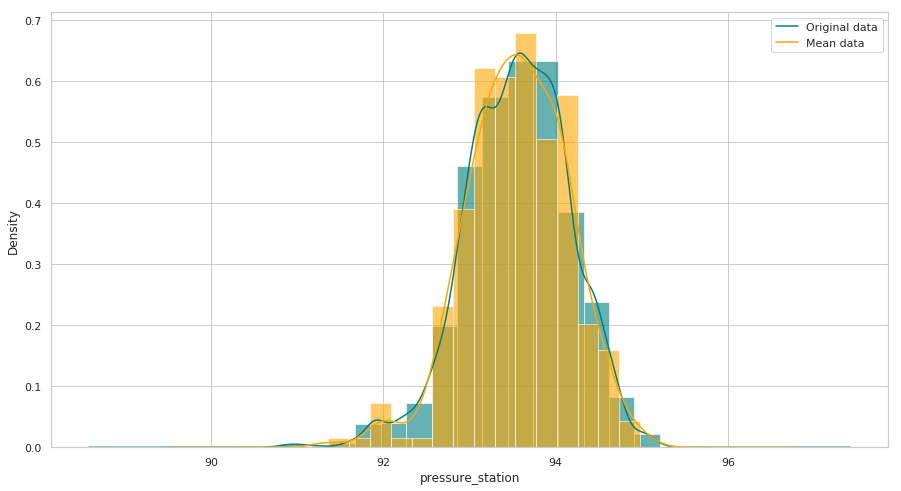

In [16]:
key_to_test = 'pressure_station'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_station_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_station_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [17]:
ks_2samp(weather_data['pressure_station'], pressure_station_mean['pressure_station'])

Ks_2sampResult(statistic=0.025696864111498297, pvalue=0.992666901639888)

#### mode

In [18]:
pressure_station_mode = weather_data.groupby('date_time_local').agg({
  'pressure_station': lambda x: x.value_counts().index[0]  
})

pressure_station_mode.describe()

,pressure_station
count,287.000000
mean,93.551463
std,0.622930
min,90.920000
25%,93.140000
50%,93.600000
75%,93.990000
max,95.060000


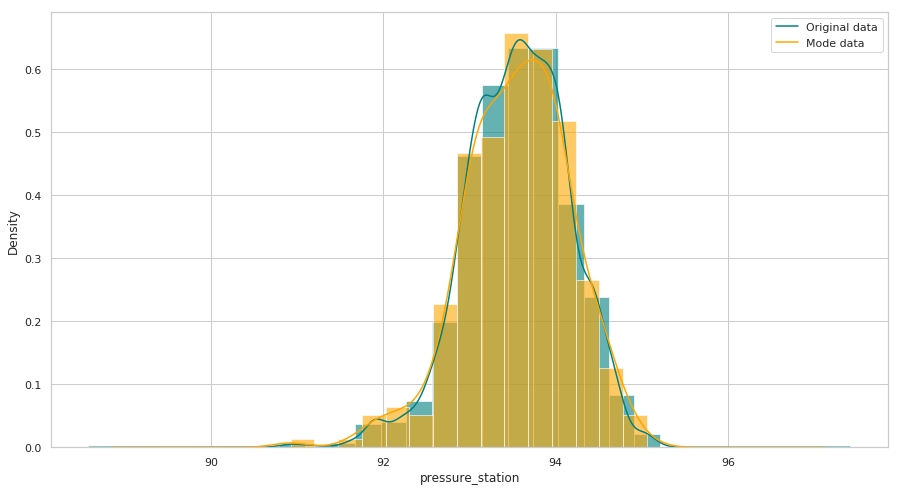

In [19]:
key_to_test = 'pressure_station'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_station_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_station_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [20]:
ks_2samp(weather_data['pressure_station'], pressure_station_mode['pressure_station'])

Ks_2sampResult(statistic=0.028310104529616686, pvalue=0.9784227183831941)

#### median

In [21]:
pressure_station_median = weather_data.groupby('date_time_local').agg({
  'pressure_station': lambda x: x.median() 
})

pressure_station_median.describe()

,pressure_station
count,287.000000
mean,93.571672
std,0.598979
min,91.110000
25%,93.190000
50%,93.575000
75%,93.997500
max,94.985000


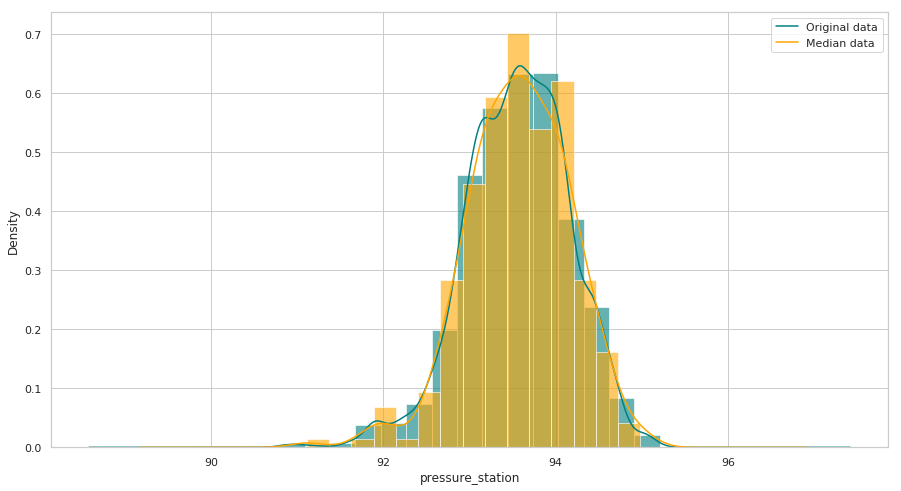

In [22]:
key_to_test = 'pressure_station'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_station_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_station_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [23]:
ks_2samp(weather_data['pressure_station'], pressure_station_median['pressure_station'])

Ks_2sampResult(statistic=0.03193960511033683, pvalue=0.9377872257810607)

It can be seen that for pressure station mode has the highest p-value so it will be chosen for grouping

### Pressure sea

In [24]:
weather_data['pressure_sea'].describe()

count    6887.000000
mean      101.402508
std         0.672463
min        98.400000
25%       100.900000
50%       101.400000
75%       101.900000
max       103.200000
Name: pressure_sea, dtype: float64

#### mean

In [25]:
pressure_sea_mean = weather_data.groupby('date_time_local').agg({
  'pressure_sea': lambda x: round(x.mean(), 2)  
})

pressure_sea_mean.describe()

,pressure_sea
count,287.000000
mean,101.402334
std,0.642834
min,99.020000
25%,100.985000
50%,101.380000
75%,101.885000
max,102.980000


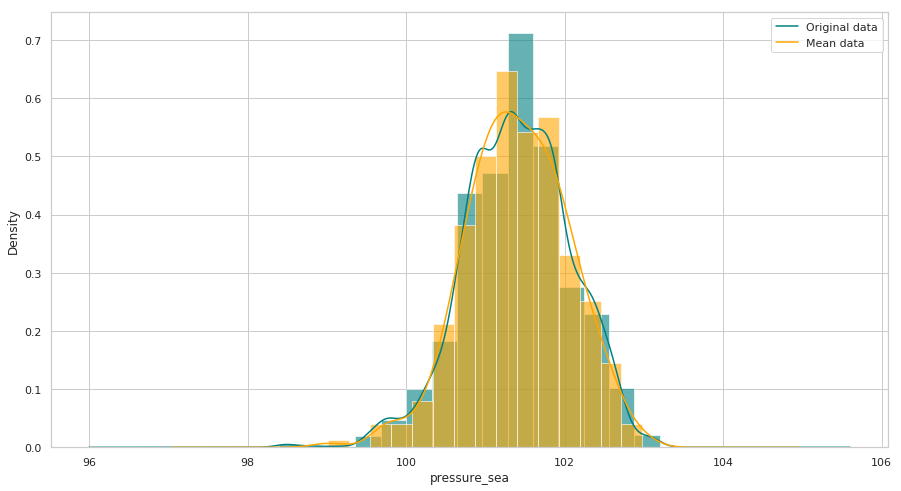

In [26]:
key_to_test = 'pressure_sea'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_sea_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_sea_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [27]:
ks_2samp(weather_data['pressure_sea'], pressure_sea_mean['pressure_sea'])

Ks_2sampResult(statistic=0.04006968641114983, pvalue=0.7601244399922262)

#### mode

In [28]:
pressure_sea_mode = weather_data.groupby('date_time_local').agg({
  'pressure_sea': lambda x: x.value_counts().index[0]  
})

pressure_sea_mode.describe()

,pressure_sea
count,287.000000
mean,101.429965
std,0.695093
min,98.500000
25%,100.950000
50%,101.400000
75%,101.900000
max,103.200000


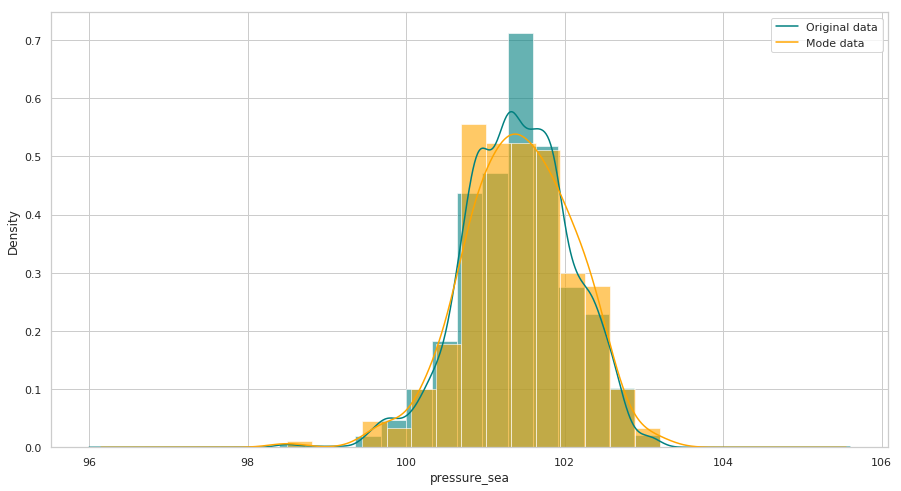

In [29]:
key_to_test = 'pressure_sea'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_sea_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_sea_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [30]:
ks_2samp(weather_data['pressure_sea'], pressure_sea_mode['pressure_sea'])

Ks_2sampResult(statistic=0.03876306620209058, pvalue=0.7945966827451194)

#### median

In [31]:
pressure_sea_median = weather_data.groupby('date_time_local').agg({
  'pressure_sea': lambda x: x.median() 
})

pressure_sea_median.describe()

,pressure_sea
count,287.000000
mean,101.419512
std,0.658571
min,98.750000
25%,101.000000
50%,101.400000
75%,101.900000
max,103.000000


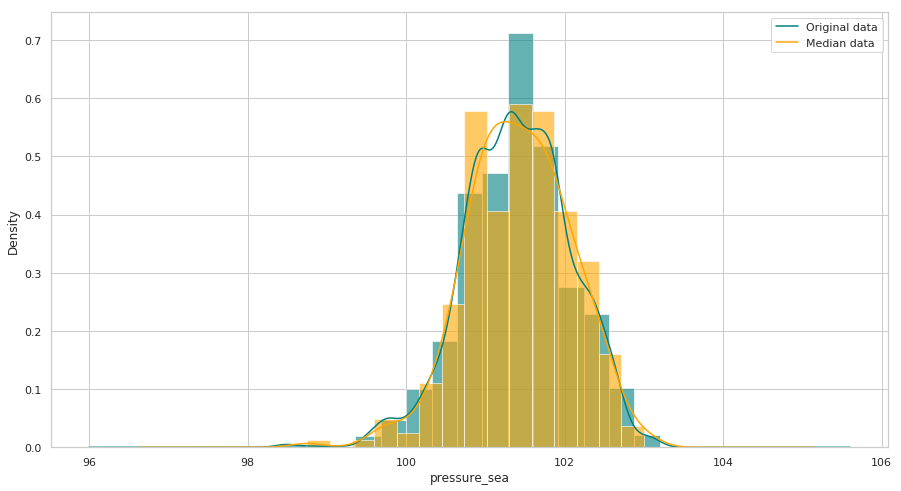

In [32]:
key_to_test = 'pressure_sea'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_sea_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_sea_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [33]:
ks_2samp(weather_data['pressure_sea'], pressure_sea_median['pressure_sea'])

Ks_2sampResult(statistic=0.034552845528455306, pvalue=0.8921107301003004)

It can be seen that for pressure sea median has the highest p-value so it will be chosen for grouping

## Wind_dir_10s
This column represents the wind direction in angles so taking a mean or median doesn't make much sense and mode is expected to be the best method.

In [34]:
weather_data['wind_dir_10s'].describe()

count    6877.000000
mean       21.359604
std         9.904530
min         1.000000
25%        14.000000
50%        23.000000
75%        30.000000
max        36.000000
Name: wind_dir_10s, dtype: float64

#### mean

In [35]:
wind_dir_10s_mean = weather_data.groupby('date_time_local').agg({
  'wind_dir_10s': lambda x: round(x.mean(), 1)  
})

wind_dir_10s_mean.describe()

,wind_dir_10s
count,287.000000
mean,21.362718
std,6.256703
min,5.600000
25%,16.800000
50%,21.900000
75%,26.700000
max,34.400000


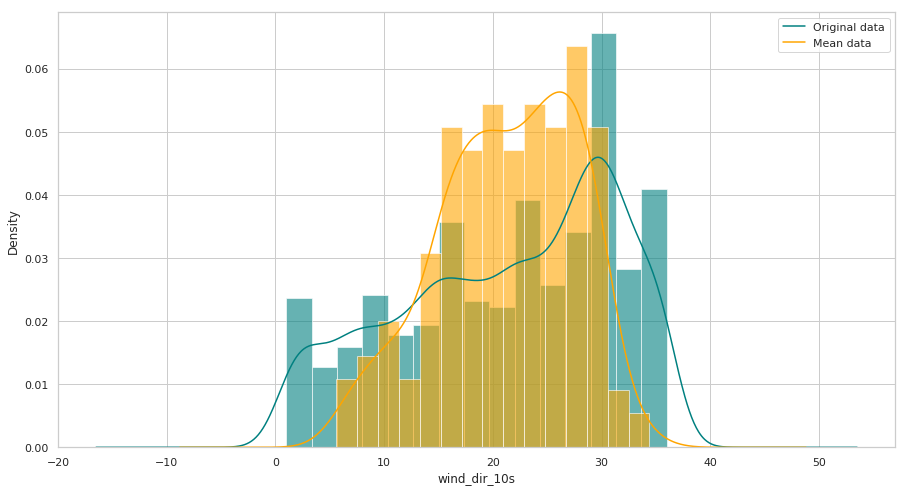

In [36]:
key_to_test = 'wind_dir_10s'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_dir_10s_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_dir_10s_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [37]:
ks_2samp(weather_data['wind_dir_10s'], wind_dir_10s_mean['wind_dir_10s'])

Ks_2sampResult(statistic=0.22604529616724733, pvalue=7.685405019192592e-13)

#### mode

In [38]:
wind_dir_10s_mode = weather_data.groupby('date_time_local').agg({
  'wind_dir_10s': lambda x: x.value_counts().index[0]   
})

wind_dir_10s_mode.describe()

,wind_dir_10s
count,287.000000
mean,22.114983
std,9.604633
min,1.000000
25%,15.000000
50%,24.000000
75%,30.000000
max,36.000000


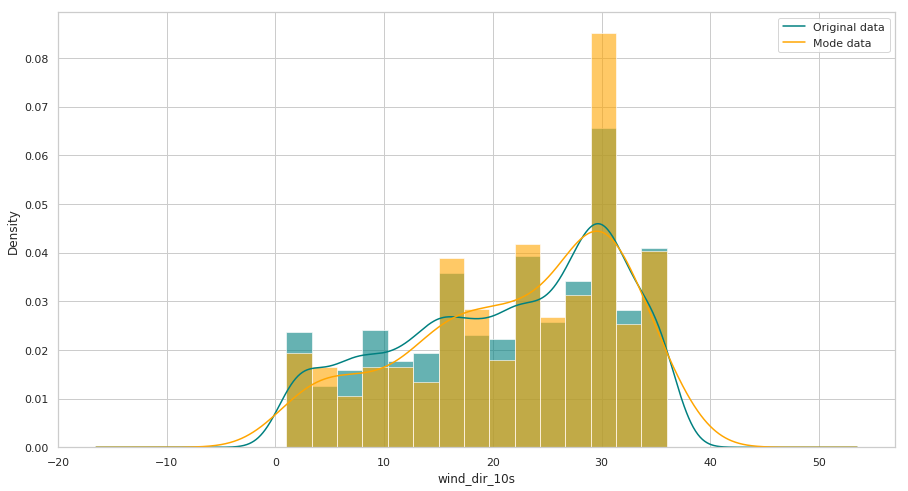

In [39]:
key_to_test = 'wind_dir_10s'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_dir_10s_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_dir_10s_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [40]:
ks_2samp(weather_data['wind_dir_10s'], wind_dir_10s_mode['wind_dir_10s'])

Ks_2sampResult(statistic=0.04863530778164926, pvalue=0.5224287549222328)

#### median

In [41]:
wind_dir_10s_median = weather_data.groupby('date_time_local').agg({
  'wind_dir_10s': lambda x: x.median()  
})

wind_dir_10s_median.describe()

,wind_dir_10s
count,287.000000
mean,21.858885
std,7.861683
min,2.500000
25%,16.250000
50%,22.000000
75%,28.500000
max,35.000000


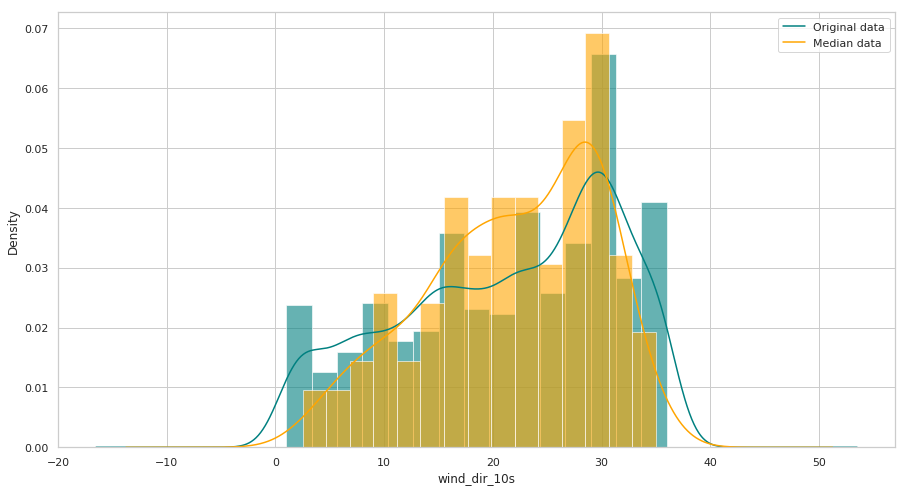

In [42]:
key_to_test = 'wind_dir_10s'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_dir_10s_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_dir_10s_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [43]:
ks_2samp(weather_data['wind_dir_10s'], wind_dir_10s_median['wind_dir_10s'])

Ks_2sampResult(statistic=0.10104529616724744, pvalue=0.0066096576088357974)

As expected mode will be the chosen value for wind_dir_10s column as it has the highest p-value, it can be seen that mean doesn't even follow the same distribution and the median barely does follow it.

## Wind_speed

In [44]:
weather_data['wind_speed'].describe()

count    6887.000000
mean       11.795992
std         6.751474
min         0.000000
25%         7.000000
50%        11.000000
75%        16.000000
max        48.000000
Name: wind_speed, dtype: float64

#### mean

In [45]:
wind_speed_mean = weather_data.groupby('date_time_local').agg({
  'wind_speed': lambda x: round(x.mean(),1)  
})

wind_speed_mean.describe()

,wind_speed
count,287.000000
mean,11.797213
std,4.450229
min,3.300000
25%,8.600000
50%,11.400000
75%,14.200000
max,34.800000


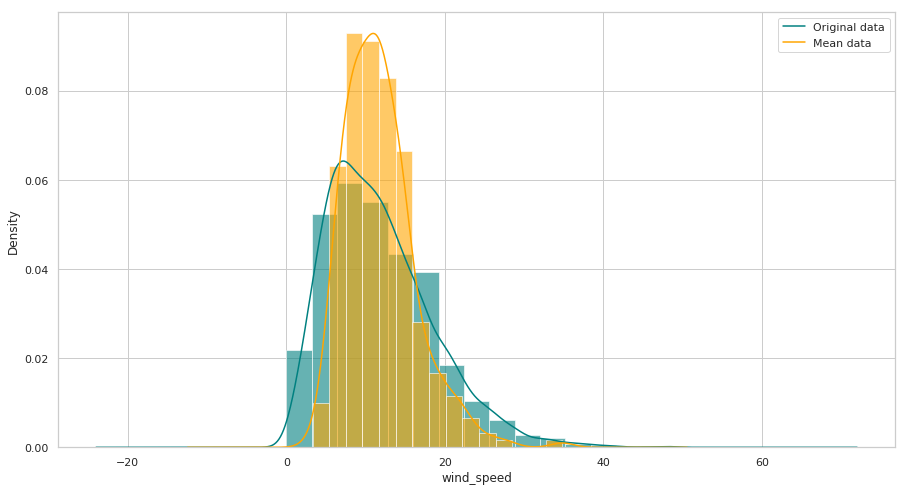

In [46]:
key_to_test = 'wind_speed'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_speed_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_speed_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [47]:
ks_2samp(weather_data['wind_speed'], wind_speed_mean['wind_speed'])

Ks_2sampResult(statistic=0.18495934959349591, pvalue=9.743900189603135e-09)

#### mode

In [48]:
wind_speed_mode = weather_data.groupby('date_time_local').agg({
  'wind_speed': lambda x: x.value_counts().index[0]  
})

wind_speed_mode.describe()

,wind_speed
count,287.000000
mean,11.184669
std,6.407822
min,1.000000
25%,6.000000
50%,10.000000
75%,14.000000
max,48.000000


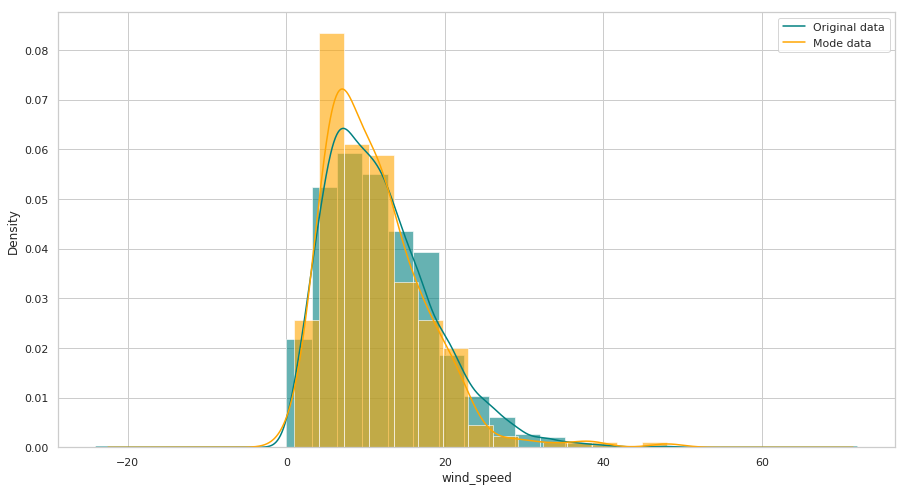

In [49]:
key_to_test = 'wind_speed'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_speed_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_speed_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [50]:
ks_2samp(weather_data['wind_speed'], wind_speed_mode['wind_speed'])

Ks_2sampResult(statistic=0.06475029036004643, pvalue=0.19139695533814222)

#### median

In [51]:
wind_speed_median = weather_data.groupby('date_time_local').agg({
  'wind_speed': lambda x: x.median()  
})

wind_speed_median.describe()

,wind_speed
count,287.000000
mean,11.529617
std,4.823818
min,3.000000
25%,8.000000
50%,11.000000
75%,14.000000
max,36.500000


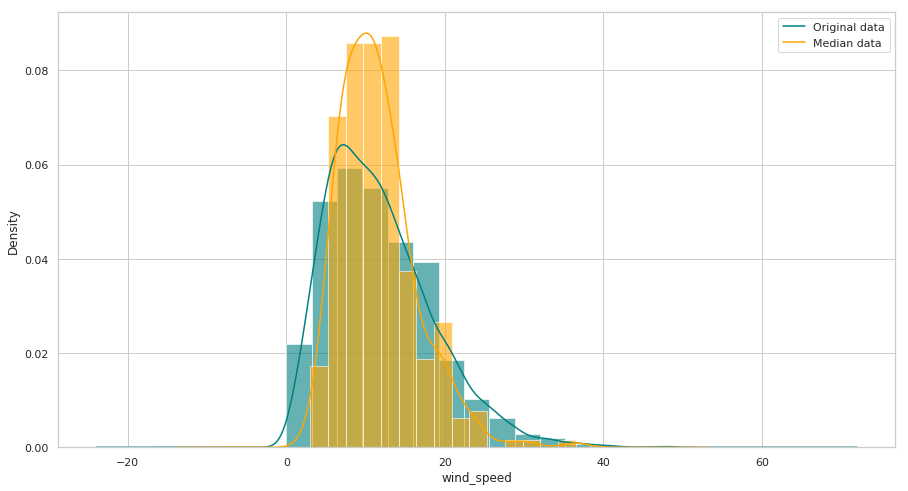

In [52]:
key_to_test = 'wind_speed'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_speed_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_speed_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [53]:
ks_2samp(weather_data['wind_speed'], wind_speed_median['wind_speed'])

Ks_2sampResult(statistic=0.13617886178861788, pvalue=6.238271787260384e-05)

Mode will be used for wind_speed

## Relative_humidty

In [54]:
weather_data['relative_humidity'].describe()

count    6887.000000
mean       59.706984
std        21.765993
min        14.000000
25%        41.000000
50%        60.000000
75%        79.000000
max        99.000000
Name: relative_humidity, dtype: float64

#### mean

In [55]:
relative_humidity_mean = weather_data.groupby('date_time_local').agg({
  'relative_humidity': lambda x: round(x.mean(),1)
})

relative_humidity_mean.describe()

,relative_humidity
count,287.000000
mean,59.707317
std,14.947495
min,27.000000
25%,48.150000
50%,59.200000
75%,69.700000
max,95.600000


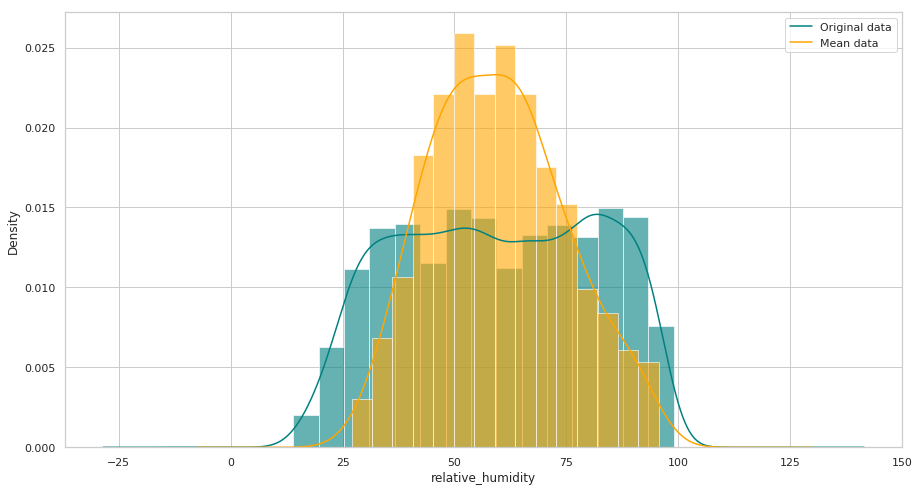

In [56]:
key_to_test = 'relative_humidity'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = relative_humidity_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
relative_humidity_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [57]:
ks_2samp(weather_data['relative_humidity'], relative_humidity_mean['relative_humidity'])

Ks_2sampResult(statistic=0.16158536585365857, pvalue=9.055100508171651e-07)

#### mode

In [58]:
relative_humidity_mode = weather_data.groupby('date_time_local').agg({
  'relative_humidity': lambda x: x.value_counts().index[0]
})

relative_humidity_mode.describe()

,relative_humidity
count,287.000000
mean,58.543554
std,25.815727
min,15.000000
25%,33.000000
50%,59.000000
75%,84.000000
max,98.000000


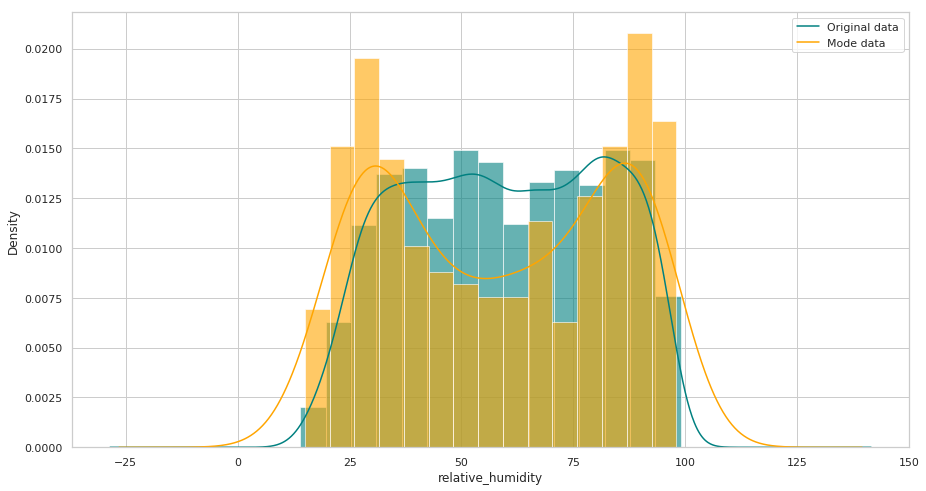

In [59]:
key_to_test = 'relative_humidity'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = relative_humidity_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
relative_humidity_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [60]:
ks_2samp(weather_data['relative_humidity'], relative_humidity_mode['relative_humidity'])

Ks_2sampResult(statistic=0.11411149825783973, pvalue=0.0013711875381521162)

#### median

In [61]:
relative_humidity_median = weather_data.groupby('date_time_local').agg({
  'relative_humidity': lambda x: x.median()
})

relative_humidity_median.describe()

,relative_humidity
count,287.000000
mean,58.599303
std,17.086567
min,20.000000
25%,45.500000
50%,57.500000
75%,70.000000
max,96.000000


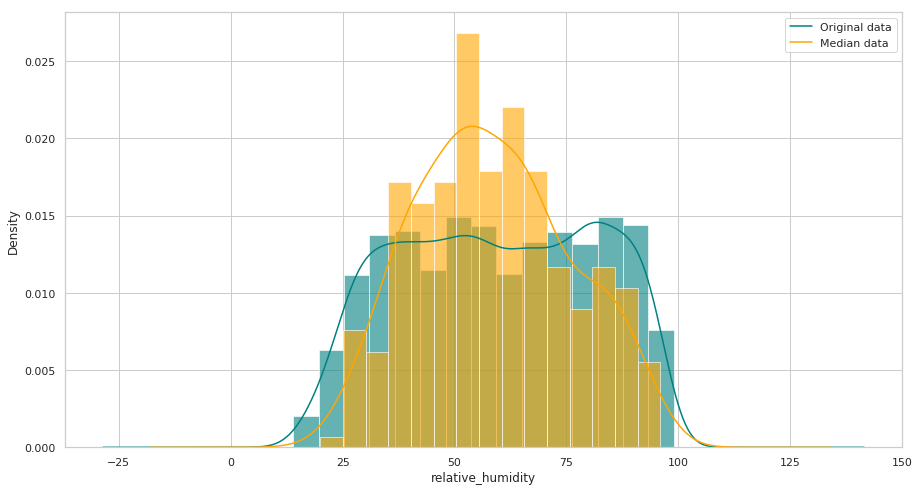

In [62]:
key_to_test = 'relative_humidity'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = relative_humidity_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
relative_humidity_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [63]:
ks_2samp(weather_data['relative_humidity'], relative_humidity_median['relative_humidity'])

Ks_2sampResult(statistic=0.1223867595818815, pvalue=0.0004587400018826103)

Grouping relative_humidty will introduce bias in the dataset so it will be ignored

## Dew_point

In [64]:
weather_data['dew_point'].describe()

count    6887.000000
mean        6.749397
std         4.366163
min        -9.800000
25%         3.400000
50%         7.000000
75%        10.200000
max        18.500000
Name: dew_point, dtype: float64

#### mean

In [65]:
dew_point_mean = weather_data.groupby('date_time_local').agg({
  'dew_point': lambda x: round(x.mean(),1)
})

dew_point_mean.describe()

,dew_point
count,287.000000
mean,6.747735
std,3.995800
min,-4.800000
25%,3.900000
50%,7.000000
75%,10.000000
max,15.200000


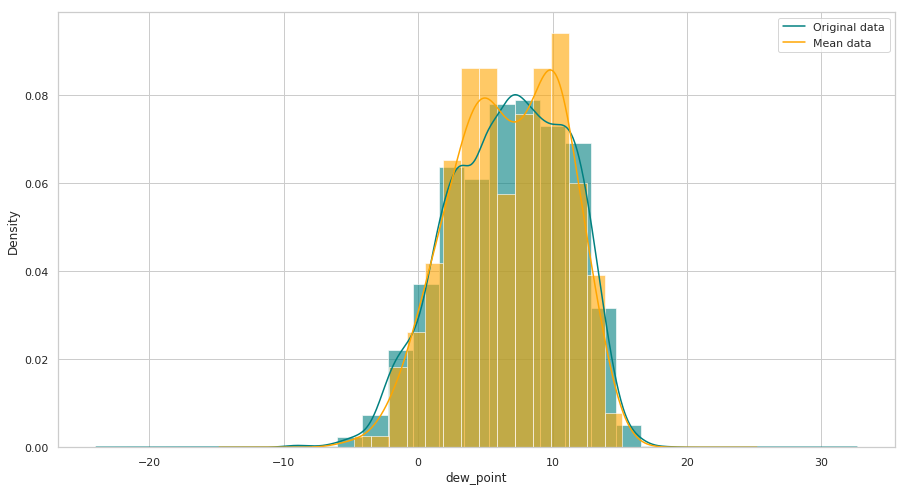

In [66]:
key_to_test = 'dew_point'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = dew_point_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
dew_point_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [67]:
ks_2samp(weather_data['dew_point'], dew_point_mean['dew_point'])

Ks_2sampResult(statistic=0.04819976771196277, pvalue=0.5341509733993717)

#### mode

In [68]:
dew_point_mode = weather_data.groupby('date_time_local').agg({
  'dew_point': lambda x: x.value_counts().index[0]
})

dew_point_mode.describe()

,dew_point
count,287.000000
mean,6.999652
std,4.215692
min,-4.800000
25%,3.500000
50%,7.100000
75%,10.550000
max,15.600000


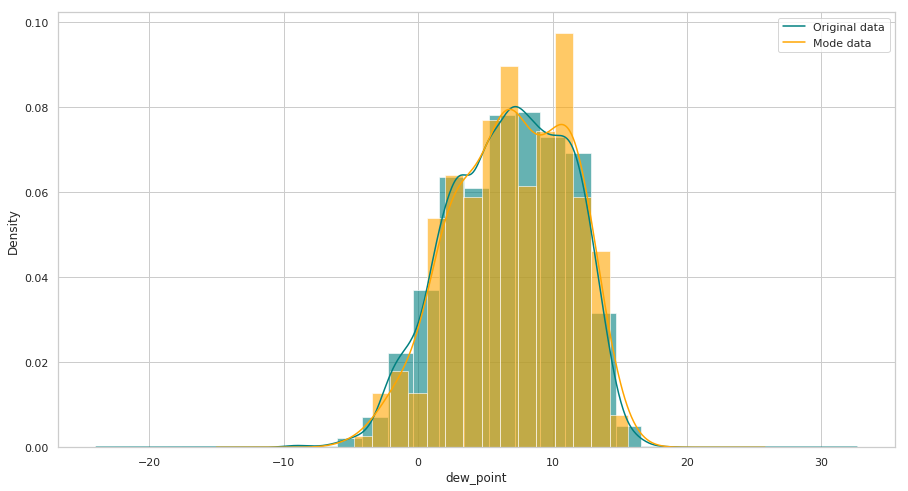

In [69]:
key_to_test = 'dew_point'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = dew_point_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
dew_point_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [70]:
ks_2samp(weather_data['dew_point'], dew_point_mode['dew_point'])

Ks_2sampResult(statistic=0.04195702671312429, pvalue=0.7083216744355756)

#### median

In [71]:
dew_point_median = weather_data.groupby('date_time_local').agg({
  'dew_point': lambda x: x.median()
})

dew_point_median.describe()

,dew_point
count,287.000000
mean,6.780662
std,4.085768
min,-4.200000
25%,3.725000
50%,7.000000
75%,10.050000
max,15.100000


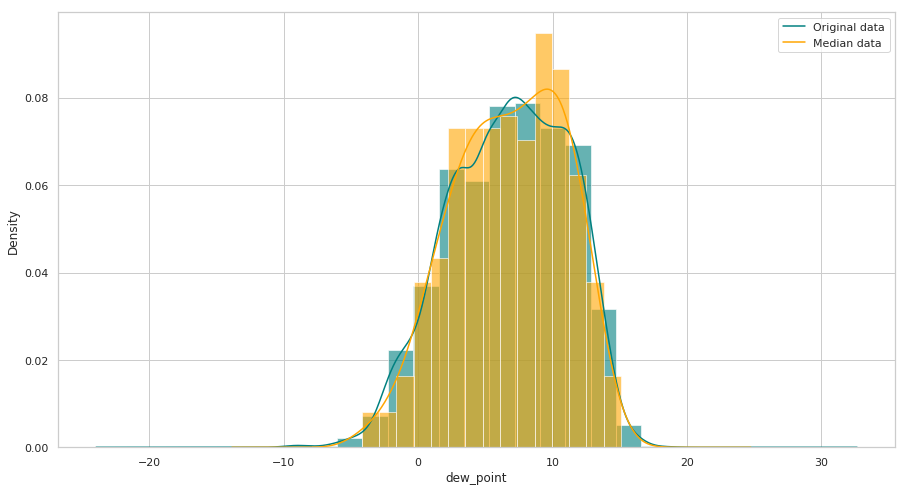

In [72]:
key_to_test = 'dew_point'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = dew_point_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
dew_point_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [73]:
ks_2samp(weather_data['dew_point'], dew_point_median['dew_point'])

Ks_2sampResult(statistic=0.04108594657375142, pvalue=0.732457942526874)

Mode will be used for dew_point

## Temperature

In [74]:
weather_data['temperature'].describe()

count    6887.000000
mean       15.785088
std         6.388398
min        -1.700000
25%        11.700000
50%        15.800000
75%        20.300000
max        34.300000
Name: temperature, dtype: float64

#### mean

In [75]:
temperature_mean = weather_data.groupby('date_time_local').agg({
  'temperature': lambda x: round(x.mean(),1)
})

temperature_mean.describe()

,temperature
count,287.000000
mean,15.786411
std,5.010938
min,-0.500000
25%,13.500000
50%,16.500000
75%,19.500000
max,25.400000


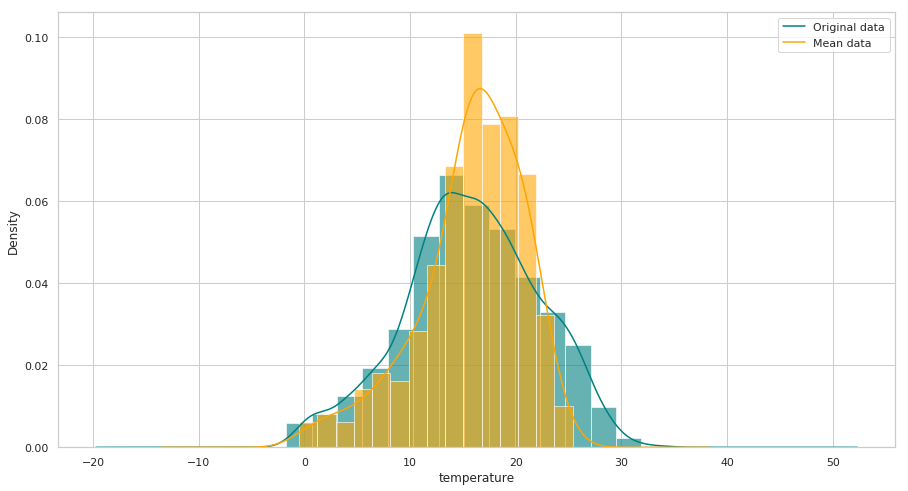

In [76]:
key_to_test = 'temperature'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = temperature_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
temperature_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [77]:
ks_2samp(weather_data['temperature'], temperature_mean['temperature'])

Ks_2sampResult(statistic=0.119773519163763, pvalue=0.0006536258612408885)

#### mode

In [78]:
temperature_mode = weather_data.groupby('date_time_local').agg({
  'temperature': lambda x: x.value_counts().index[0]
})

temperature_mode.describe()

,temperature
count,287.000000
mean,15.369686
std,6.863796
min,-1.500000
25%,11.000000
50%,15.000000
75%,19.800000
max,31.800000


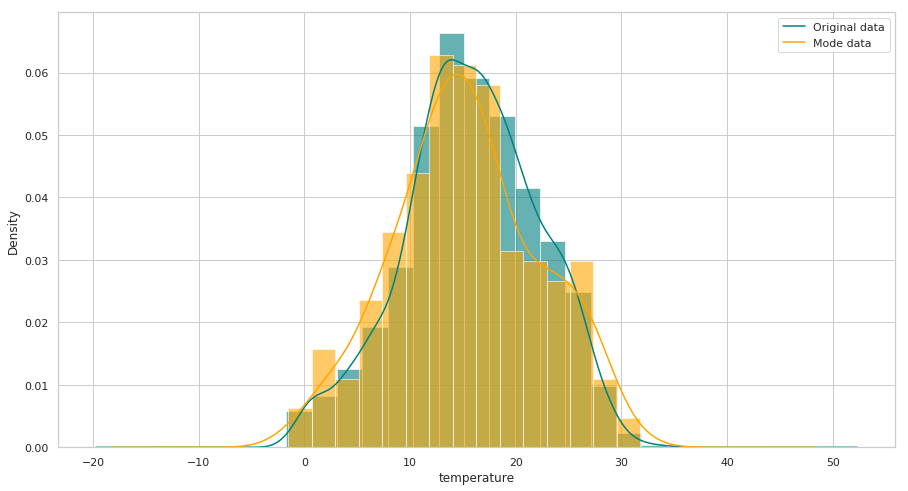

In [79]:
key_to_test = 'temperature'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = temperature_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
temperature_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [80]:
ks_2samp(weather_data['temperature'], temperature_mode['temperature'])

Ks_2sampResult(statistic=0.057346109175377524, pvalue=0.31639666640347086)

#### median

In [81]:
temperature_median = weather_data.groupby('date_time_local').agg({
  'temperature': lambda x: x.median()
})

temperature_median.describe()

,temperature
count,287.000000
mean,15.882578
std,5.206690
min,-0.550000
25%,13.550000
50%,16.500000
75%,19.600000
max,26.250000


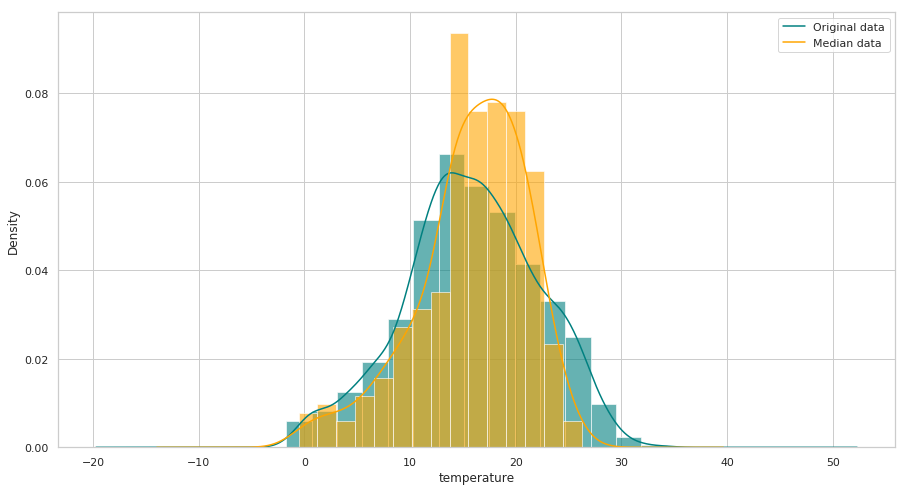

In [82]:
key_to_test = 'temperature'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = temperature_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
temperature_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [83]:
ks_2samp(weather_data['temperature'], temperature_median['temperature'])

Ks_2sampResult(statistic=0.11846689895470386, pvalue=0.0007779757375291689)

Mode will be used for temperature

## Health_index

In [84]:
weather_data['health_index'].describe()

count    6838.000000
mean        2.601843
std         1.215754
min         1.000000
25%         1.900000
50%         2.400000
75%         3.000000
max        11.000000
Name: health_index, dtype: float64

#### mean

In [85]:
health_index_mean = weather_data.groupby('date_time_local').agg({
  'health_index': lambda x: round(x.mean(),1)
})

health_index_mean.describe()

,health_index
count,287.000000
mean,2.599303
std,1.006170
min,1.000000
25%,2.000000
50%,2.400000
75%,2.900000
max,7.900000


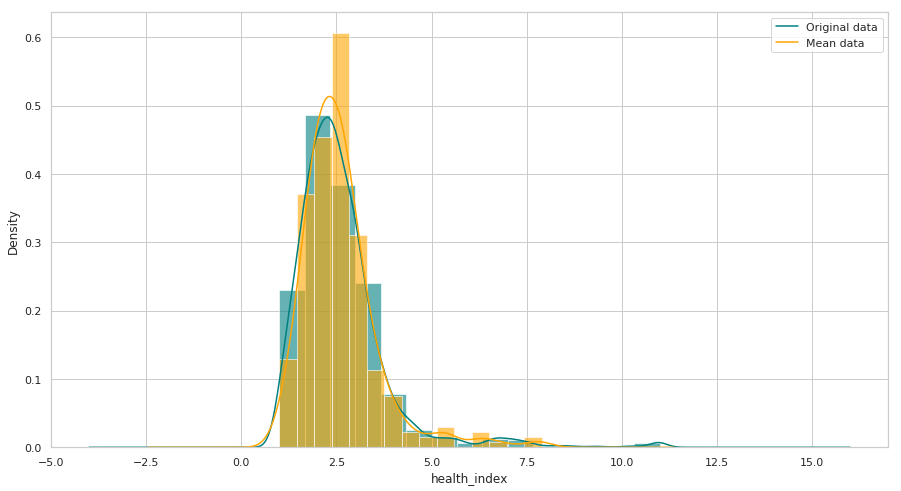

In [86]:
key_to_test = 'health_index'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = health_index_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
health_index_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [87]:
ks_2samp(weather_data['health_index'], health_index_mean['health_index'])

Ks_2sampResult(statistic=0.062427409988385585, pvalue=0.2256681435228581)

#### mode

In [88]:
health_index_mode = weather_data.groupby('date_time_local').agg({
  'health_index': lambda x: x.value_counts().index[0]
})

health_index_mode.describe()

,health_index
count,287.000000
mean,2.504530
std,1.212845
min,1.000000
25%,1.900000
50%,2.300000
75%,2.900000
max,11.000000


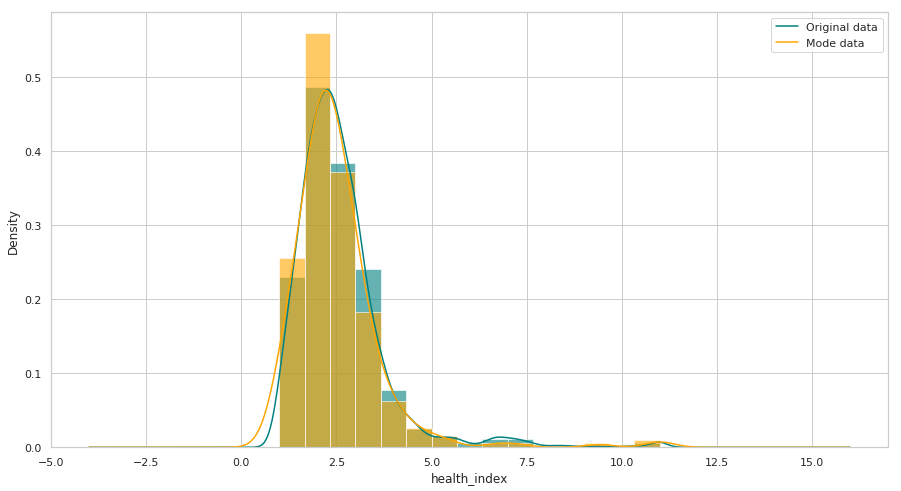

In [89]:
key_to_test = 'health_index'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = health_index_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
health_index_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [90]:
ks_2samp(weather_data['health_index'], health_index_mode['health_index'])

Ks_2sampResult(statistic=0.06997677119628337, pvalue=0.12915362020302915)

#### median

In [91]:
health_index_median = weather_data.groupby('date_time_local').agg({
  'health_index': lambda x: x.median()
})

health_index_median.describe()

,health_index
count,287.000000
mean,2.521080
std,0.959895
min,1.000000
25%,1.950000
50%,2.400000
75%,2.900000
max,7.650000


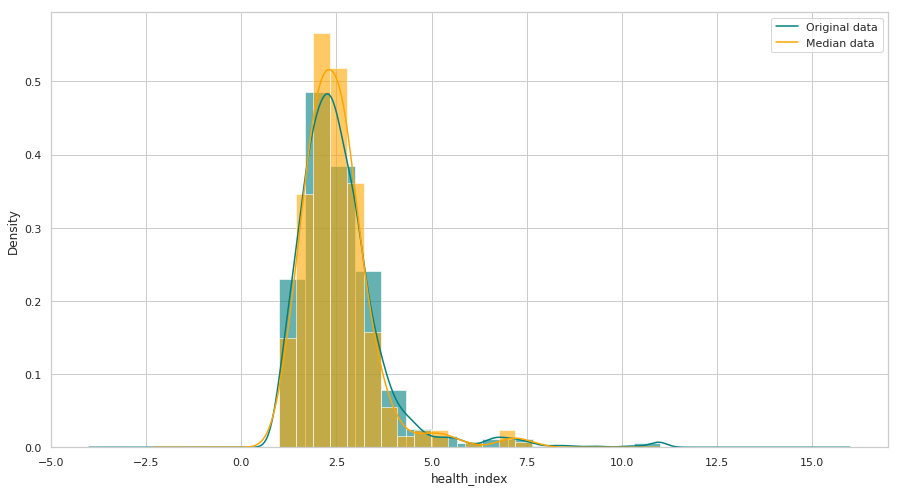

In [92]:
key_to_test = 'health_index'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = health_index_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
health_index_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [93]:
ks_2samp(weather_data['health_index'], health_index_median['health_index'])

Ks_2sampResult(statistic=0.06692799070847855, pvalue=0.16308173105903004)

Mean will be used for health_index

## Grouping weather data by date
- Pressure station by mode
- Pressure sea by median
- wind_dir_10s by mode
- wind_speed by mode
- relative_humidty ignored
- dew_point by mode
- temperature by mode
- health_index by mean

In [94]:
weather_data_grouped = weather_data.groupby('date_time_local', as_index=False).agg({
    'pressure_station': lambda x: x.value_counts().index[0],
    'pressure_sea': lambda x: x.median(),
    'wind_dir_10s': lambda x: x.value_counts().index[0],
    'wind_speed': lambda x: x.value_counts().index[0],
    'dew_point': lambda x: x.value_counts().index[0],
    'temperature': lambda x: x.value_counts().index[0],
    'health_index': lambda x: round(x.mean(), 1)
})

print(len(weather_data_grouped.index))

weather_data_grouped.head()

287


,date_time_local,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-03,93.87,101.50,20.0,7.0,-1.6,18.9,2.8
1,2017-05-04,93.64,101.40,22.0,7.0,1.9,8.4,3.2
2,2017-05-05,92.13,100.25,15.0,13.0,4.6,27.2,2.8
3,2017-05-06,92.68,100.30,28.0,13.0,5.2,14.9,2.4
4,2017-05-07,93.48,101.30,31.0,18.0,-3.0,6.3,2.2


In [95]:
weather_data_grouped.isnull().sum()

date_time_local     0
pressure_station    0
pressure_sea        0
wind_dir_10s        0
wind_speed          0
dew_point           0
temperature         0
health_index        0
dtype: int64

#### Further group weather data by week

In [96]:
weather_data_grouped.sort_values('date_time_local', inplace=True)
weather_data_grouped.head(7)

,date_time_local,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-03,93.87,101.50,20.0,7.0,-1.6,18.9,2.8
1,2017-05-04,93.64,101.40,22.0,7.0,1.9,8.4,3.2
2,2017-05-05,92.13,100.25,15.0,13.0,4.6,27.2,2.8
3,2017-05-06,92.68,100.30,28.0,13.0,5.2,14.9,2.4
4,2017-05-07,93.48,101.30,31.0,18.0,-3.0,6.3,2.2
5,2017-05-08,93.54,101.60,31.0,8.0,-4.8,14.0,2.9
6,2017-05-09,93.62,101.60,32.0,7.0,2.1,16.7,2.9


In [97]:
weather_data_grouped = weather_data_grouped.groupby(weather_data_grouped.index // 7).agg({
    'date_time_local': 'last',
    'pressure_station': lambda x: x.value_counts().index[0],
    'pressure_sea': lambda x: x.median(),
    'wind_dir_10s': lambda x: x.value_counts().index[0],
    'wind_speed': lambda x: x.value_counts().index[0],
    'dew_point': lambda x: x.value_counts().index[0],
    'temperature': lambda x: x.value_counts().index[0],
    'health_index': lambda x: round(x.mean(), 1)
})

print(len(weather_data_grouped.index))

41


## Grouping mosquito data


There are 3 candidate columns to group mosquito data by:
- Trap_date: date of trapping mosquitos
- Genus: When biologists talk about a genus, they mean one or more species of animals or plants that are closely related to each other. Low-level taxonomic ranking for biological classification.
- Specific Epithet: lowest taxonomic rank and having common characteristics and (usually) capable of mating with one another.

Add Gender for part B

In [98]:
mos_data.head()

,Trap Date,Genus,Specific Epithet,Gender,Count,Trap Region,Comparison Group,Latitude,Longitude,Location
7163,2017-05-09,Culiseta,alaskaensis,Female,2,Outer Community-South1,Outer,53.333327,-113.531374,POINT (-113.5313737 53.3333269)
9856,2017-05-09,Culiseta,spp.,Female,2,River Valley-East-P1,Core,53.581417,-113.374561,POINT (-113.3745611 53.58141700000001)
19436,2017-05-09,Culiseta,alaskaensis,Female,2,Rural-South West,Peripheral,53.528587,-113.738070,POINT (-113.7380701 53.5285872)
17781,2017-05-09,Culiseta,inornata,Female,1,Rural-North West,Peripheral,53.619232,-113.712798,POINT (-113.7127984 53.6192317)
8338,2017-05-09,Culiseta,incidens,Female,1,Rural-North West,Peripheral,53.619232,-113.712798,POINT (-113.7127984 53.6192317)


In [99]:
# mos_data_grouped = mos_data.groupby(['Trap Date'], as_index=False).agg({
#     'Count' : 'sum',
#     'Genus': lambda x: x.value_counts().index[0],
#     'Gender': lambda x: x.value_counts().index[0]
# })

mos_data_grouped = mos_data.groupby(['Trap Date', 'Genus'], as_index=False).agg({
    'Count' : 'sum',
    'Gender': lambda x: x.value_counts().index[0],
    'Specific Epithet': lambda x: x.value_counts().index[0],
})

print(len(mos_data_grouped.index))

mos_data_grouped.head()

264


,Trap Date,Genus,Count,Gender,Specific Epithet
0,2017-05-09,Culex,1,Female,territans
1,2017-05-09,Culiseta,25,Female,inornata
2,2017-05-16,Culiseta,8,Female,inornata
3,2017-05-16,Male,6,Male,UnID
4,2017-05-16,Ochlerotatus,15,Female,Black legs


In [100]:
merged_data = pd.merge(left=mos_data_grouped, right=weather_data_grouped, left_on='Trap Date', right_on='date_time_local')

print(len(merged_data.index))

merged_data.drop(columns=['date_time_local'], inplace=True) #redundent

merged_data.head()

264


,Trap Date,Genus,Count,Gender,Specific Epithet,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-09,Culex,1,Female,territans,93.87,101.4,31.0,7.0,5.2,6.3,2.7
1,2017-05-09,Culiseta,25,Female,inornata,93.87,101.4,31.0,7.0,5.2,6.3,2.7
2,2017-05-16,Culiseta,8,Female,inornata,92.94,100.9,11.0,12.0,5.3,2.4,2.4
3,2017-05-16,Male,6,Male,UnID,92.94,100.9,11.0,12.0,5.3,2.4,2.4
4,2017-05-16,Ochlerotatus,15,Female,Black legs,92.94,100.9,11.0,12.0,5.3,2.4,2.4


In [101]:
merged_data.isnull().sum()

Trap Date           0
Genus               0
Count               0
Gender              0
Specific Epithet    0
pressure_station    0
pressure_sea        0
wind_dir_10s        0
wind_speed          0
dew_point           0
temperature         0
health_index        0
dtype: int64

## Add features
- isWarm: if temperature is above 20 = 1, else = 0.
- add genusCat for Genus
- add genderCat female = 1, male = 0
- add delta_pressure = pressure_station - pressure_sea

In [102]:
merged_data['isWarm'] = np.where(merged_data['temperature'] >= 20, 1, 0)

In [103]:
merged_data['isWindy'] = np.where(merged_data['wind_speed'] >= 25, 1, 0)

In [104]:
merged_data['Genus'] = merged_data['Genus'].astype('category')
merged_data['genusCat'] = merged_data['Genus'].cat.codes

In [105]:
merged_data['Specific Epithet'] = merged_data['Specific Epithet'].astype('category')
merged_data['epithetCat'] = merged_data['Specific Epithet'].cat.codes

In [106]:
merged_data['genderCat'] = np.where(merged_data['Gender'] == "Female", 1, 0)

In [107]:
merged_data["delta_pressure"] = merged_data.apply(lambda x: x['pressure_station'] - x['pressure_sea'], axis=1)

In [108]:
merged_data.head()

,Trap Date,Genus,Count,Gender,Specific Epithet,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index,isWarm,isWindy,genusCat,epithetCat,genderCat,delta_pressure
0,2017-05-09,Culex,1,Female,territans,93.87,101.4,31.0,7.0,5.2,6.3,2.7,0,0,2,13,1,-7.53
1,2017-05-09,Culiseta,25,Female,inornata,93.87,101.4,31.0,7.0,5.2,6.3,2.7,0,0,3,9,1,-7.53
2,2017-05-16,Culiseta,8,Female,inornata,92.94,100.9,11.0,12.0,5.3,2.4,2.4,0,0,3,9,1,-7.96
3,2017-05-16,Male,6,Male,UnID,92.94,100.9,11.0,12.0,5.3,2.4,2.4,0,0,4,1,0,-7.96
4,2017-05-16,Ochlerotatus,15,Female,Black legs,92.94,100.9,11.0,12.0,5.3,2.4,2.4,0,0,7,0,1,-7.96


# Part A: Linear Regression for no_of_Mosquito = function(weather_features)

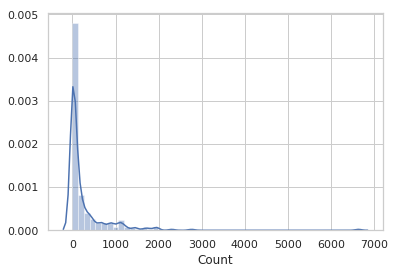

In [109]:
sns.distplot(merged_data['Count'])

In [110]:
merged_data['Count'].describe()

count     264.000000
mean      281.761364
std       598.922245
min         1.000000
25%         9.000000
50%        45.500000
75%       284.500000
max      6637.000000
Name: Count, dtype: float64

In [111]:
#merged_data = merged_data[merged_data['Count'] < merged_data['Count'].describe()['75%']]  

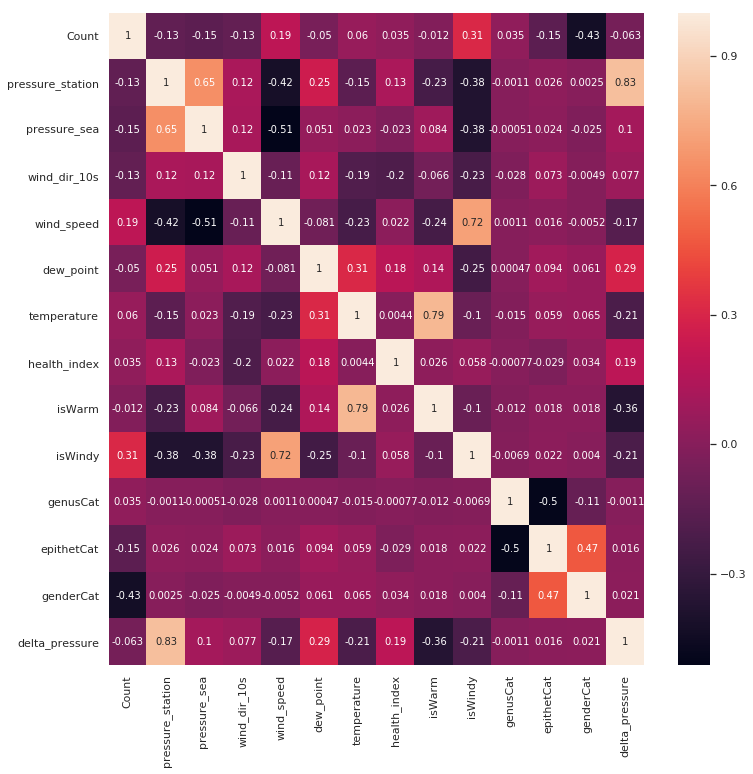

In [112]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(merged_data.corr(), annot=True, ax=ax)

In [113]:
x_cols = ['wind_speed', 'temperature', 'health_index', 'isWindy','genderCat','epithetCat']
X = merged_data[x_cols]
y = merged_data['Count']

In [114]:
from sklearn.preprocessing import StandardScaler

x_cols = ['temperature', 'wind_speed', 'health_index']


X_stand = X.copy()
X_norm = X.copy()
X_both = X.copy()

X_stand[x_cols] = StandardScaler().fit_transform(X[x_cols])
X_norm[x_cols] = X[x_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
X_both[x_cols] = StandardScaler().fit_transform(X[x_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))[x_cols])

In [115]:
from sklearn.model_selection import train_test_split

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train_stand, X_test_stand, y_train_stand, y_test_stand = train_test_split(X_stand, y, test_size=test_size, random_state=42)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y, test_size=test_size, random_state=42)
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(X_both, y, test_size=test_size, random_state=42)


In [116]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [117]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

lin_reg_norm = LinearRegression()
lin_reg_norm.fit(X_train_norm,y_train_norm)

lin_reg_stand = LinearRegression()
lin_reg_stand.fit(X_train_stand,y_train_stand)

lin_reg_both = LinearRegression()
lin_reg_both.fit(X_train_both,y_train_both)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [118]:
print(lin_reg.intercept_)
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

627.8104176765585


,Coefficient
wind_speed,-1.830030
temperature,9.712425
health_index,29.942135
isWindy,1261.791833
genderCat,-765.544835
epithetCat,6.951263


In [119]:
print(lin_reg_norm.intercept_)
coeff_df = pd.DataFrame(lin_reg_norm.coef_, X.columns, columns=['Coefficient'])
coeff_df

660.3863175714628


,Coefficient
wind_speed,-60.390975
temperature,269.034180
health_index,131.745394
isWindy,1261.791833
genderCat,-765.544835
epithetCat,6.951263


In [120]:
print(lin_reg_stand.intercept_)
coeff_df = pd.DataFrame(lin_reg_stand.coef_, X.columns, columns=['Coefficient'])
coeff_df

843.9180371161974


,Coefficient
wind_speed,-11.095885
temperature,63.487760
health_index,21.115769
isWindy,1261.791833
genderCat,-765.544835
epithetCat,6.951263


In [121]:
print(lin_reg_both.intercept_)
coeff_df = pd.DataFrame(lin_reg_both.coef_, X.columns, columns=['Coefficient'])
coeff_df

843.9180371161965


,Coefficient
wind_speed,-11.095885
temperature,63.487760
health_index,21.115769
isWindy,1261.791833
genderCat,-765.544835
epithetCat,6.951263


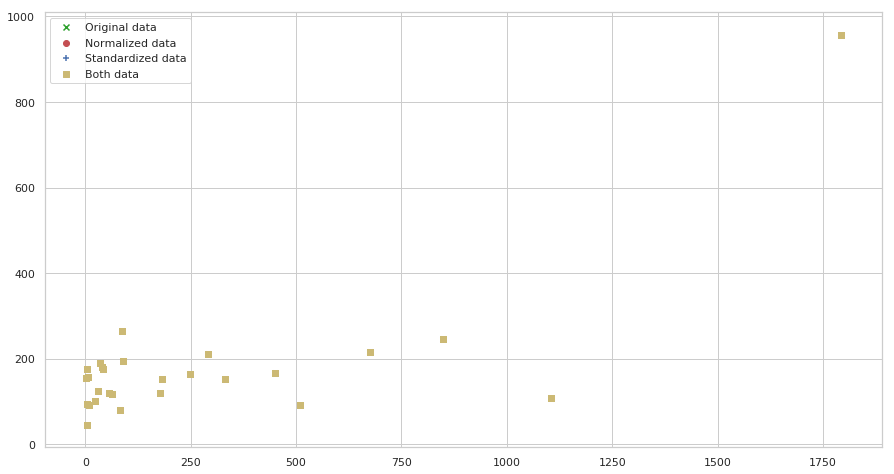

In [122]:
pred = lin_reg.predict(X_test)
pred_norm = lin_reg_norm.predict(X_test_norm)
pred_stand = lin_reg_stand.predict(X_test_stand)
pred_both = lin_reg_both.predict(X_test_both)


plt.figure(figsize=(15, 8))
ax = plt.gca()

ax.scatter(y_test, pred, c='#2ca02c', marker='x', label='Original data')
ax.scatter(y_test_norm, pred, c='r', marker='o', label='Normalized data')
ax.scatter(y_test_stand, pred, c='b', marker='+', label='Standardized data')
ax.scatter(y_test_both, pred, c='y', marker='s', label='Both data')

plt.legend(loc='best');

plt.show()

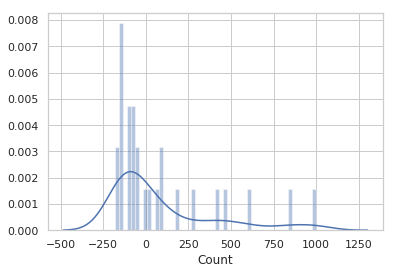

In [123]:
sns.distplot((y_test - pred), bins=50);

In [124]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 212.22982483982403
MSE: 103507.9876424494
RMSE: 321.72657279505125
R2 Square 0.38121558245181897
Train set evaluation:
_____________________________________
MAE: 271.9384658105728
MSE: 265231.2070098192
RMSE: 515.0060261878682
R2 Square 0.3001290629454646


In [125]:
test_pred_norm = lin_reg_norm.predict(X_test_norm)
train_pred_norm = lin_reg_norm.predict(X_train_norm)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_norm, test_pred_norm)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_norm, train_pred_norm)

Test set evaluation:
_____________________________________
MAE: 212.22982483982457
MSE: 103507.98764244941
RMSE: 321.72657279505125
R2 Square 0.38121558245181886
Train set evaluation:
_____________________________________
MAE: 271.93846581057255
MSE: 265231.20700981916
RMSE: 515.0060261878682
R2 Square 0.30012906294546493


In [126]:
test_pred_stand = lin_reg_stand.predict(X_test_stand)
train_pred_stand = lin_reg_stand.predict(X_train_stand)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_stand, test_pred_stand)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_stand, train_pred_stand)

Test set evaluation:
_____________________________________
MAE: 212.22982483982452
MSE: 103507.98764244934
RMSE: 321.72657279505114
R2 Square 0.3812155824518193
Train set evaluation:
_____________________________________
MAE: 271.9384658105728
MSE: 265231.20700981916
RMSE: 515.0060261878682
R2 Square 0.30012906294546493


In [127]:
test_pred_both = lin_reg_both.predict(X_test_both)
train_pred_both = lin_reg_both.predict(X_train_both)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_both, test_pred_both)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_both, train_pred_both)

Test set evaluation:
_____________________________________
MAE: 212.22982483982446
MSE: 103507.9876424494
RMSE: 321.72657279505125
R2 Square 0.38121558245181897
Train set evaluation:
_____________________________________
MAE: 271.9384658105728
MSE: 265231.20700981916
RMSE: 515.0060261878682
R2 Square 0.30012906294546493


In [128]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())], ["Linear Regression w/ norm", *evaluate(y_test_norm, test_pred_norm) , cross_val(LinearRegression())], ["Linear Regression w/ stand", *evaluate(y_test_stand, test_pred_stand) , cross_val(LinearRegression())],["Linear Regression w/ both", *evaluate(y_test_both, test_pred_both) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,212.229825,103507.987642,321.726573,0.381216,-1.041831
1,Linear Regression w/ norm,212.229825,103507.987642,321.726573,0.381216,-1.041831
2,Linear Regression w/ stand,212.229825,103507.987642,321.726573,0.381216,-1.041831
3,Linear Regression w/ both,212.229825,103507.987642,321.726573,0.381216,-1.041831


# Part B: count depending on Gender

In [129]:
# mos_data_grouped_B = mos_data.groupby(['Trap Date', 'Gender'], as_index=False).agg({
#     'Count' : 'sum',
#     'Genus': lambda x: x.value_counts().index[0],
# })

mos_data_grouped_B = mos_data.groupby(['Trap Date', 'Gender', 'Specific Epithet'], as_index=False).agg({
    'Count' : 'sum',
    'Genus': lambda x: x.value_counts().index[0],
})

print(len(mos_data_grouped_B.index))

mos_data_grouped_B.head()

657


,Trap Date,Gender,Specific Epithet,Count,Genus
0,2017-05-09,Female,alaskaensis,4,Culiseta
1,2017-05-09,Female,incidens,1,Culiseta
2,2017-05-09,Female,inornata,18,Culiseta
3,2017-05-09,Female,spp.,2,Culiseta
4,2017-05-09,Female,territans,1,Culex


In [130]:
mos_data_grouped_B_females = mos_data_grouped_B[mos_data_grouped_B["Gender"] == "Female"]
mos_data_grouped_B_males = mos_data_grouped_B[mos_data_grouped_B["Gender"] == "Male"]

In [131]:
print(len(mos_data_grouped_B_females.index), len(mos_data_grouped_B_males.index))

617 40


## Linear Regression

### Females

In [132]:
merged_data_females = pd.merge(left=mos_data_grouped_B_females, right=weather_data_grouped, left_on='Trap Date', right_on='date_time_local')

print(len(merged_data_females.index))

merged_data_females.drop(columns=['date_time_local'], inplace=True) #redundent

merged_data_females.head()

617


,Trap Date,Gender,Specific Epithet,Count,Genus,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-09,Female,alaskaensis,4,Culiseta,93.87,101.4,31.0,7.0,5.2,6.3,2.7
1,2017-05-09,Female,incidens,1,Culiseta,93.87,101.4,31.0,7.0,5.2,6.3,2.7
2,2017-05-09,Female,inornata,18,Culiseta,93.87,101.4,31.0,7.0,5.2,6.3,2.7
3,2017-05-09,Female,spp.,2,Culiseta,93.87,101.4,31.0,7.0,5.2,6.3,2.7
4,2017-05-09,Female,territans,1,Culex,93.87,101.4,31.0,7.0,5.2,6.3,2.7


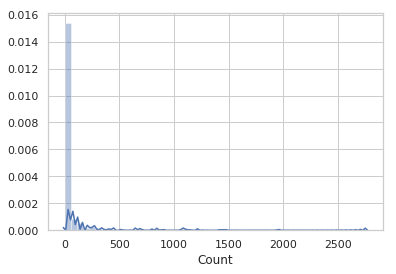

In [133]:
sns.distplot(merged_data_females['Count'])

In [134]:
merged_data_females['isWarm'] = np.where(merged_data_females['temperature'] >= 20, 1, 0)

In [135]:
merged_data_females['isWindy'] = np.where(merged_data_females['wind_speed'] >= 25, 1, 0)

In [136]:
merged_data_females['Genus'] = merged_data_females['Genus'].astype('category')
merged_data_females['genusCat'] = merged_data_females['Genus'].cat.codes

In [137]:
merged_data_females['Specific Epithet'] = merged_data_females['Specific Epithet'].astype('category')
merged_data_females['epithetCat'] = merged_data_females['Specific Epithet'].cat.codes

In [138]:
merged_data_females["delta_pressure"] = merged_data_females.apply(lambda x: x['pressure_station'] - x['pressure_sea'], axis=1)

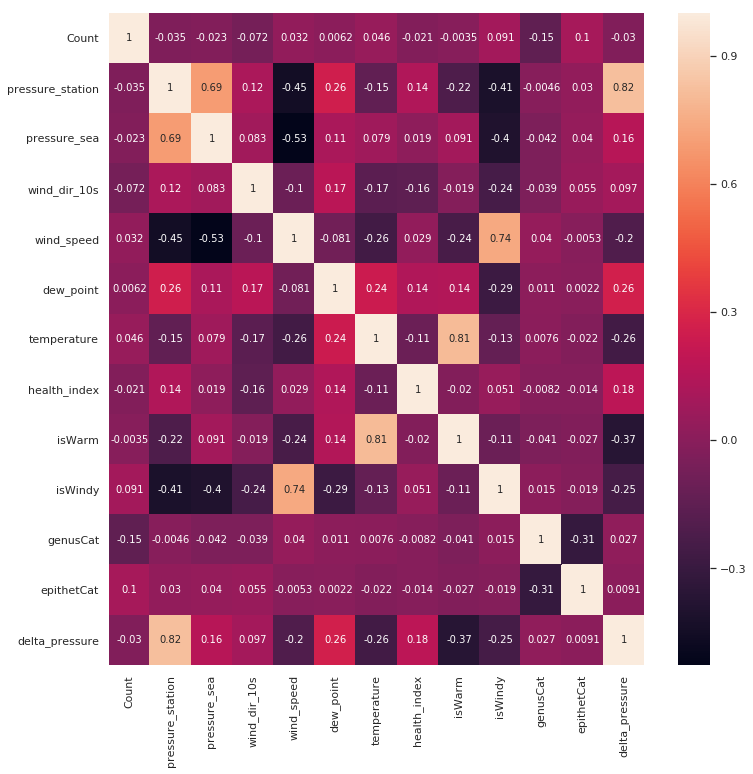

In [139]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(merged_data_females.corr(), annot=True, ax=ax)

In [140]:

x_cols = ['wind_speed', 'dew_point', 'temperature',  'isWindy', 'epithetCat']

X = merged_data_females[x_cols]
y = merged_data_females['Count']

In [141]:
from sklearn.preprocessing import StandardScaler

x_cols = ['wind_speed', 'dew_point', 'temperature']


X_stand = X.copy()
X_norm = X.copy()
X_both = X.copy()

X_stand[x_cols] = StandardScaler().fit_transform(X[x_cols])
X_norm[x_cols] = X[x_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
X_both[x_cols] = StandardScaler().fit_transform(X[x_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))[x_cols])

In [142]:
from sklearn.model_selection import train_test_split

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train_stand, X_test_stand, y_train_stand, y_test_stand = train_test_split(X_stand, y, test_size=test_size, random_state=42)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y, test_size=test_size, random_state=42)
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(X_both, y, test_size=test_size, random_state=42)


In [143]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [144]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

lin_reg_norm = LinearRegression()
lin_reg_norm.fit(X_train_norm,y_train_norm)

lin_reg_stand = LinearRegression()
lin_reg_stand.fit(X_train_stand,y_train_stand)

lin_reg_both = LinearRegression()
lin_reg_both.fit(X_train_both,y_train_both)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [145]:
print(lin_reg.intercept_)
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

1.053854346938678


,Coefficient
wind_speed,-2.802008
dew_point,3.337223
temperature,1.287292
isWindy,250.363151
epithetCat,3.595997


In [146]:
print(lin_reg_norm.intercept_)
coeff_df = pd.DataFrame(lin_reg_norm.coef_, X.columns, columns=['Coefficient'])
coeff_df

-7.68939170893357


,Coefficient
wind_speed,-92.466260
dew_point,44.051346
temperature,35.657993
isWindy,250.363151
epithetCat,3.595997


In [147]:
print(lin_reg_stand.intercept_)
coeff_df = pd.DataFrame(lin_reg_stand.coef_, X.columns, columns=['Coefficient'])
coeff_df

18.32177052846759


,Coefficient
wind_speed,-17.689130
dew_point,11.733338
temperature,7.905364
isWindy,250.363151
epithetCat,3.595997


In [148]:
print(lin_reg_both.intercept_)
coeff_df = pd.DataFrame(lin_reg_both.coef_, X.columns, columns=['Coefficient'])
coeff_df

18.321770528467646


,Coefficient
wind_speed,-17.689130
dew_point,11.733338
temperature,7.905364
isWindy,250.363151
epithetCat,3.595997


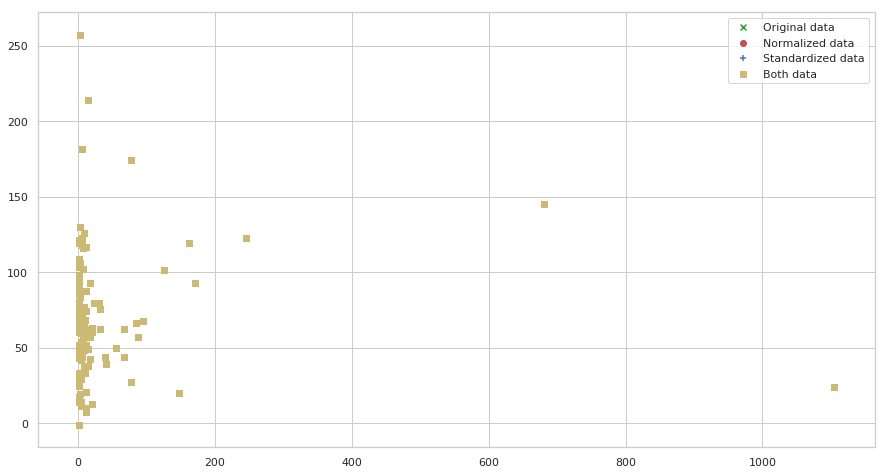

In [149]:
pred = lin_reg.predict(X_test)
pred_norm = lin_reg_norm.predict(X_test_norm)
pred_stand = lin_reg_stand.predict(X_test_stand)
pred_both = lin_reg_both.predict(X_test_both)


plt.figure(figsize=(15, 8))
ax = plt.gca()

ax.scatter(y_test, pred, c='#2ca02c', marker='x', label='Original data')
ax.scatter(y_test_norm, pred, c='r', marker='o', label='Normalized data')
ax.scatter(y_test_stand, pred, c='b', marker='+', label='Standardized data')
ax.scatter(y_test_both, pred, c='y', marker='s', label='Both data')

plt.legend(loc='best');

plt.show()

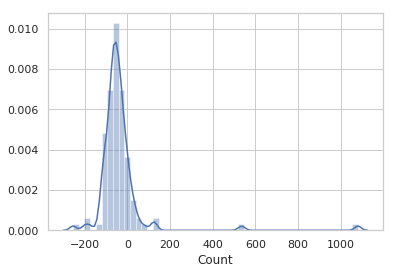

In [150]:
sns.distplot((y_test - pred), bins=50);

In [151]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 71.94050128191928
MSE: 16872.598553689335
RMSE: 129.8945670676389
R2 Square -0.18411825257842218
Train set evaluation:
_____________________________________
MAE: 103.1494719166057
MSE: 53425.43186618037
RMSE: 231.13942083984801
R2 Square 0.03131275888057927


In [152]:
test_pred_norm = lin_reg_norm.predict(X_test_norm)
train_pred_norm = lin_reg_norm.predict(X_train_norm)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_norm, test_pred_norm)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_norm, train_pred_norm)

Test set evaluation:
_____________________________________
MAE: 71.94050128191924
MSE: 16872.598553689324
RMSE: 129.89456706763883
R2 Square -0.1841182525784213
Train set evaluation:
_____________________________________
MAE: 103.14947191660569
MSE: 53425.43186618037
RMSE: 231.13942083984801
R2 Square 0.03131275888057927


In [153]:
test_pred_stand = lin_reg_stand.predict(X_test_stand)
train_pred_stand = lin_reg_stand.predict(X_train_stand)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_stand, test_pred_stand)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_stand, train_pred_stand)

Test set evaluation:
_____________________________________
MAE: 71.94050128191925
MSE: 16872.598553689335
RMSE: 129.8945670676389
R2 Square -0.18411825257842218
Train set evaluation:
_____________________________________
MAE: 103.14947191660572
MSE: 53425.43186618038
RMSE: 231.13942083984804
R2 Square 0.03131275888057916


In [154]:
test_pred_both = lin_reg_both.predict(X_test_both)
train_pred_both = lin_reg_both.predict(X_train_both)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_both, test_pred_both)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_both, train_pred_both)

Test set evaluation:
_____________________________________
MAE: 71.94050128191925
MSE: 16872.59855368933
RMSE: 129.89456706763886
R2 Square -0.18411825257842174
Train set evaluation:
_____________________________________
MAE: 103.1494719166057
MSE: 53425.43186618037
RMSE: 231.13942083984801
R2 Square 0.03131275888057927


In [155]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())], ["Linear Regression w/ norm", *evaluate(y_test_norm, test_pred_norm) , cross_val(LinearRegression())], ["Linear Regression w/ stand", *evaluate(y_test_stand, test_pred_stand) , cross_val(LinearRegression())],["Linear Regression w/ both", *evaluate(y_test_both, test_pred_both) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,71.940501,16872.598554,129.894567,-0.184118,-0.092115
1,Linear Regression w/ norm,71.940501,16872.598554,129.894567,-0.184118,-0.092115
2,Linear Regression w/ stand,71.940501,16872.598554,129.894567,-0.184118,-0.092115
3,Linear Regression w/ both,71.940501,16872.598554,129.894567,-0.184118,-0.092115


## Polynomial Regression

In [156]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

In [157]:
# merged_data_males = pd.merge(left=mos_data_grouped_B_males, right=weather_data_grouped, left_on='Trap Date', right_on='date_time_local')

# print(len(merged_data_males.index))

# merged_data_males.drop(columns=['date_time_local'], inplace=True) #redundent

# merged_data_males.head()

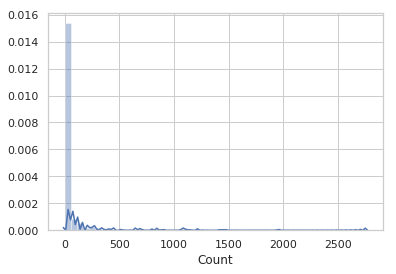

In [158]:
sns.distplot(merged_data_females['Count'])

In [159]:
# merged_data_males['isWarm'] = np.where(merged_data_males['temperature'] >= 20, 1, 0)

In [160]:
# merged_data_males['Genus'] = merged_data_males['Genus'].astype('category')
# merged_data_males['genusCat'] = merged_data_males['Genus'].cat.codes

In [161]:
# merged_data_males["delta_pressure"] = merged_data_males.apply(lambda x: x['pressure_station'] - x['pressure_sea'], axis=1)

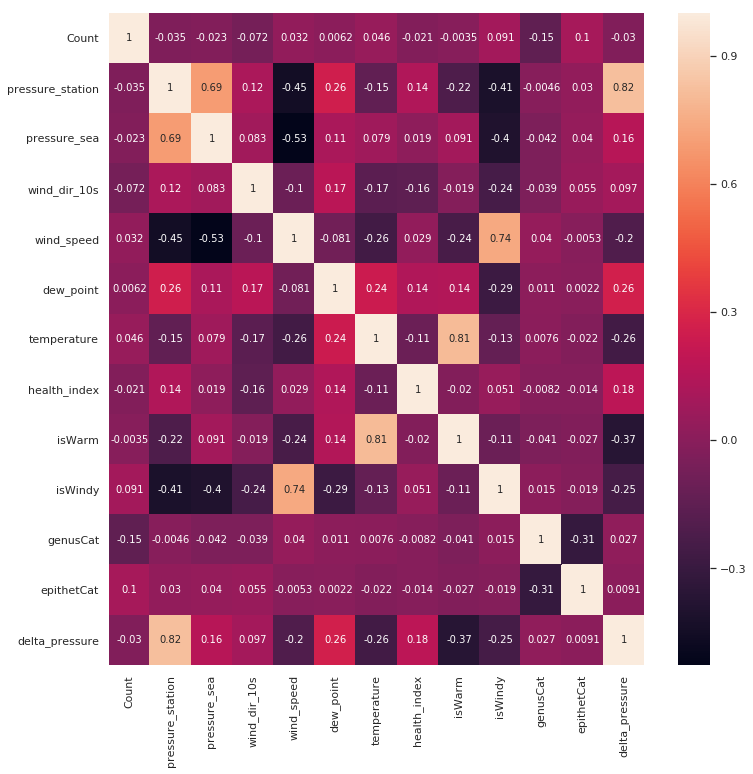

In [162]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(merged_data_females.corr(), annot=True, ax=ax)

In [163]:
x_cols = [ 'wind_speed','dew_point' ,'temperature', 'isWindy', 'epithetCat']
X = merged_data_females[x_cols]
y = merged_data_females['Count']

In [164]:
def compute_mse(X_train, Y_train, X_test, Y_test, n_degree=11):
    train_mse = []
    test_mse = []
    for degree in range(1,n_degree):
        poly_features = PolynomialFeatures(degree=degree)
        sklreg = LinearRegression()
        pipeline = Pipeline([("polynomial_features", poly_features),
                             ("linear_regression", sklreg)])
        pipeline.fit(X_train, Y_train)
        Y_train_pred = pipeline.predict(X_train)
        Y_test_pred = pipeline.predict(X_test)

        train_mse.append(mean_squared_error(Y_train, Y_train_pred))
        test_mse.append(mean_squared_error(Y_test, Y_test_pred))
    return train_mse,test_mse

In [165]:
from sklearn.preprocessing import StandardScaler

x_cols = ['wind_speed', 'temperature', 'dew_point']


X_stand = X.copy()
X_norm = X.copy()
X_both = X.copy()

X_stand[x_cols] = StandardScaler().fit_transform(X[x_cols])
X_norm[x_cols] = X[x_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
X_both[x_cols] = StandardScaler().fit_transform(X[x_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))[x_cols])

In [166]:
from sklearn.model_selection import train_test_split

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train_stand, X_test_stand, y_train_stand, y_test_stand = train_test_split(X_stand, y, test_size=test_size, random_state=42)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y, test_size=test_size, random_state=42)
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(X_both, y, test_size=test_size, random_state=42)

In [167]:
train_mse,test_mse = compute_mse(X_train,y_train,X_test,y_test)
train_mse_stand,test_mse_stand, = compute_mse(X_train_stand,y_train_stand,X_test_stand,y_test_stand)
train_mse_norm,test_mse_norm = compute_mse(X_train_norm,y_train_norm,X_test_norm,y_test_norm)
train_mse_both,test_mse_both = compute_mse(X_train_both,y_train_both,X_test_both,y_test_both)

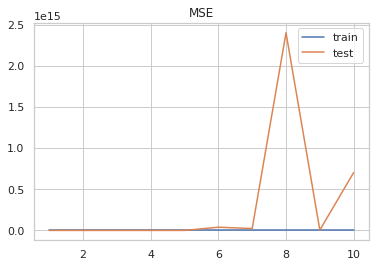

In [168]:
plt.plot(range(1,len(train_mse)+1),train_mse, label='train')
plt.plot(range(1,len(test_mse)+1),test_mse, label='test')
plt.title('MSE')
plt.legend()

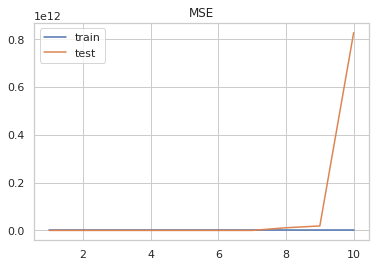

In [169]:
plt.plot(range(1,len(train_mse_stand)+1),train_mse_stand, label='train')
plt.plot(range(1,len(test_mse_stand)+1),test_mse_stand, label='test')
plt.title('MSE')
plt.legend()

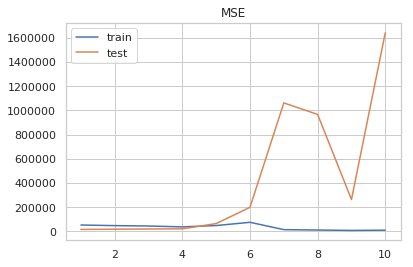

In [170]:
plt.plot(range(1,len(train_mse_norm)+1),train_mse_norm, label='train')
plt.plot(range(1,len(test_mse_norm)+1),test_mse_norm, label='test')
plt.title('MSE')
plt.legend()

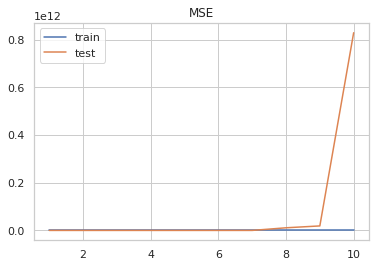

In [171]:
plt.plot(range(1,len(train_mse_both)+1),train_mse_both, label='train')
plt.plot(range(1,len(test_mse_both)+1),test_mse_both, label='test')
plt.title('MSE')
plt.legend()

In [172]:
print("Best degree none: ",np.argmin(train_mse)+1)
print("Best degree standarization: ",np.argmin(train_mse_stand)+1)
print("Best degree normalization: ",np.argmin(train_mse_norm)+1)
print("Best degree both: ",np.argmin(train_mse_both)+1)

Best degree none:  10
Best degree standarization:  10
Best degree normalization:  9
Best degree both:  10


In [173]:
poly_features = PolynomialFeatures(degree=np.argmin(train_mse)+1, include_bias=False)
X_poly = poly_features.fit_transform(X)

poly_features_stand = PolynomialFeatures(degree=np.argmin(train_mse_stand )+1, include_bias=False)
X_poly_stand = poly_features_stand.fit_transform(X_stand)

poly_features_norm = PolynomialFeatures(degree=np.argmin(train_mse_norm)+1, include_bias=False)
X_poly_norm = poly_features_norm.fit_transform(X_norm)

poly_features_both = PolynomialFeatures(degree=np.argmin(train_mse_both)+1, include_bias=False)
X_poly_both = poly_features_both.fit_transform(X_both)

In [174]:
X_best = SelectKBest(f_regression,5).fit_transform(X_poly, y)
X_best_stand = SelectKBest(f_regression,5).fit_transform(X_poly_stand, y)
X_best_norm = SelectKBest(f_regression,5).fit_transform(X_poly_norm, y)
X_best_both = SelectKBest(f_regression,5).fit_transform(X_poly_both, y)

In [175]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_best,y)

lin_reg_norm = LinearRegression()
lin_reg_norm.fit(X_best_norm,y)

lin_reg_stand = LinearRegression()
lin_reg_stand.fit(X_best_stand,y)

lin_reg_both = LinearRegression()
lin_reg_both.fit(X_best_both,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

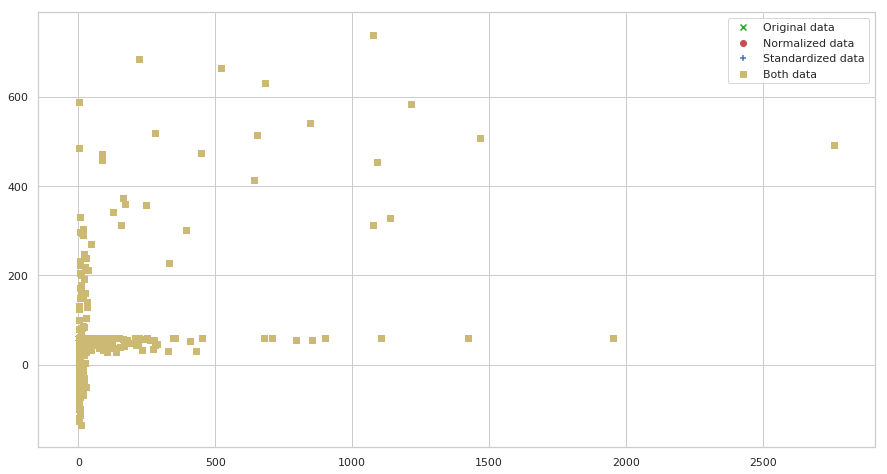

In [176]:
pred = lin_reg.predict(X_best)
pred_norm = lin_reg_norm.predict(X_best_norm)
pred_stand = lin_reg_stand.predict(X_best_stand)
pred_both = lin_reg_both.predict(X_best_both)


plt.figure(figsize=(15, 8))
ax = plt.gca()

ax.scatter(y, pred, c='#2ca02c', marker='x', label='Original data')
ax.scatter(y, pred, c='r', marker='o', label='Normalized data')
ax.scatter(y, pred, c='b', marker='+', label='Standardized data')
ax.scatter(y, pred, c='y', marker='s', label='Both data')

plt.legend(loc='best');

plt.show()

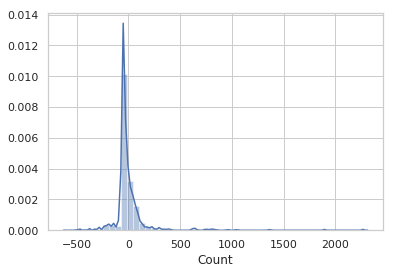

In [177]:
sns.distplot((y - pred), bins=50);

In [178]:
print('Train set evaluation:\n_____________________________________')
print_evaluate(y, pred)

Train set evaluation:
_____________________________________
MAE: 84.4851880075416
MSE: 36541.94296640137
RMSE: 191.1594699888064
R2 Square 0.22524371154020817


In [179]:
print('Train set evaluation:\n_____________________________________')
print_evaluate(y, pred_norm)

Train set evaluation:
_____________________________________
MAE: 86.11593383251154
MSE: 37064.48649710655
RMSE: 192.52139231032626
R2 Square 0.21416482920546065


In [180]:
print('Train set evaluation:\n_____________________________________')
print_evaluate(y, pred_stand)

Train set evaluation:
_____________________________________
MAE: 77.7805897345031
MSE: 36907.80281449049
RMSE: 192.11403596429514
R2 Square 0.21748681097631073


In [181]:
print('Train set evaluation:\n_____________________________________')
print_evaluate(y, pred_both)

Train set evaluation:
_____________________________________
MAE: 77.7805897345031
MSE: 36907.80281449049
RMSE: 192.11403596429514
R2 Square 0.21748681097631073


In [182]:
results_df = pd.DataFrame(data=[["Polynomial Regression", *evaluate(y, pred) , cross_val(LinearRegression())], ["Polynomial Regression w/ norm", *evaluate(y, pred_norm) , cross_val(LinearRegression())], ["Polynomial Regression w/ stand", *evaluate(y, pred_stand) , cross_val(LinearRegression())],["Polynomial Regression w/ both", *evaluate(y, pred_both) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Polynomial Regression,84.485188,36541.942966,191.159470,0.225244,-0.092115
1,Polynomial Regression w/ norm,86.115934,37064.486497,192.521392,0.214165,-0.092115
2,Polynomial Regression w/ stand,77.780590,36907.802814,192.114036,0.217487,-0.092115
3,Polynomial Regression w/ both,77.780590,36907.802814,192.114036,0.217487,-0.092115
